# EM Lab – Ensemble Methods on UCI Student Performance

This notebook implements the **EM Lab** assignment end-to-end, following the lab PDF:
- **Concept overview:** bagging, boosting, voting (majority / soft).  
- **Models:** Random Forest (bagging), Gradient Boosting (boosting), **VotingClassifier**, plus baseline Logistic Regression and Decision Tree.  
- **Evaluation:** Accuracy, Precision, Recall, F1, confusion matrices, feature importance plots.  
- **Data:** UCI Student Performance (Portuguese & Math) — already uploaded locally.  

> Target variable: convert **G3** (0–20) to binary **High vs. Low performance**.

> ### How to run
> 1. Run the Imports cell.  
> 2. Run the **Load & Combine Data** cell (uses your local files in `/mnt/data`).  
> 3. Execute **Preprocessing**, **Baselines**, **Ensembles**, and **Comparison** cells in order.  
> 4. Answer the **Reflective Questions** at the end.

In [17]:
# !pip install scikit-learn pandas numpy matplotlib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Concepts at a Glance
- **Bagging**: Train many base learners on bootstrap samples; aggregate to reduce *variance*. → Example: **Random Forest**.  
- **Boosting**: Train learners sequentially, focusing on previous errors; reduces *bias* (and can affect variance). → Example: **Gradient Boosting**.  
- **Voting**: Combine predictions of diverse models via **hard voting** (majority class) or **soft voting** (average probabilities).

## Load & Combine Data
We will:
1. Load **Portuguese** (`student-por.csv`) and **Math** (`student-mat.csv`) from the local path `/mnt/data/`.  
2. Add a `subject` column and **concatenate** both datasets for modeling.  
3. (Optional) Demonstrate the **382 overlapping students** when merging on the keys used in the R script.

In [18]:
# Local paths (already uploaded)
POR_PATH = r"student-mat.csv"
MAT_PATH = r"student-mat.csv"

# Read (UCI CSVs use semicolons ';')
por = pd.read_csv(POR_PATH, sep=';')
mat = pd.read_csv(MAT_PATH, sep=';')

por = por.copy()
mat = mat.copy()
por['subject'] = 'por'
mat['subject'] = 'mat'

# Optional: confirm overlap = 382 using merge keys from student-merge.R
merge_keys = ["school","sex","age","address","famsize","Pstatus",
              "Medu","Fedu","Mjob","Fjob","reason","nursery","internet"]
overlap = pd.merge(mat, por, on=merge_keys, suffixes=('_mat','_por'))
print("Overlapping students (should be 382):", len(overlap))

# For modeling: concatenate with subject column
df = pd.concat([por, mat], ignore_index=True)

print("Combined shape:", df.shape)
display(df.head())
print(df.describe().T)

Overlapping students (should be 382): 403
Combined shape: (790, 34)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,subject
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,6,5,6,6,por
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,4,5,5,6,por
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,10,7,8,10,por
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,2,15,14,15,por
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,4,6,10,10,por


            count       mean       std   min   25%   50%   75%   max
age         790.0  16.696203  1.275234  15.0  16.0  17.0  18.0  22.0
Medu        790.0   2.749367  1.094041   0.0   2.0   3.0   4.0   4.0
Fedu        790.0   2.521519  1.087511   0.0   2.0   2.0   3.0   4.0
traveltime  790.0   1.448101  0.697063   1.0   1.0   1.0   2.0   4.0
studytime   790.0   2.035443  0.838708   1.0   1.0   2.0   2.0   4.0
failures    790.0   0.334177  0.743180   0.0   0.0   0.0   0.0   3.0
famrel      790.0   3.944304  0.896090   1.0   4.0   4.0   5.0   5.0
freetime    790.0   3.235443  0.998229   1.0   3.0   3.0   4.0   5.0
goout       790.0   3.108861  1.112572   1.0   2.0   3.0   4.0   5.0
Dalc        790.0   1.481013  0.890177   1.0   1.0   1.0   2.0   5.0
Walc        790.0   2.291139  1.287080   1.0   1.0   2.0   3.0   5.0
health      790.0   3.554430  1.389422   1.0   3.0   4.0   5.0   5.0
absences    790.0   5.708861  7.998022   0.0   0.0   4.0   8.0  75.0
G1          790.0  10.908861  3.31

## Target Engineering: High vs. Low Final Performance
We convert `G3` (0–20) into a binary target `target` using a configurable threshold (default: **12**).  
We keep `G1`, `G2` as predictors (early/second period grades), which are highly informative.

In [19]:
THRESHOLD = 12  # change if desired
df = df.copy()
df['target'] = (df['G3'] >= THRESHOLD).astype(int)

# Features (drop target + G3 to avoid direct leakage of final grade)
y = df['target']
X = df.drop(columns=['target','G3'])

# Identify categorical & numeric columns
categorical_cols = [c for c in X.columns if X[c].dtype == 'object']
numeric_cols = [c for c in X.columns if c not in categorical_cols]

print("Categorical:", len(categorical_cols), "| Numeric:", len(numeric_cols))

Categorical: 18 | Numeric: 15


## Preprocessing
- **Impute**: Most frequent for categoricals; median for numerics.  
- **Encode**: One-hot for categoricals.  
- **Scale**: Standardize numeric features.  
- **Split**: Train/test with stratification.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))  # keep sparse compatibility
])

preprocess = ColumnTransformer(transformers=[
    ('cat', categorical_pipeline, categorical_cols),
    ('num', numeric_pipeline, numeric_cols)
])

In [21]:
def evaluate_and_plot(model, X_te, y_te, title=None):
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, zero_division=0)
    rec = recall_score(y_te, y_pred, zero_division=0)
    f1 = f1_score(y_te, y_pred, zero_division=0)
    print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
    print("\nClassification report:\n", classification_report(y_te, y_pred, zero_division=0))
    ConfusionMatrixDisplay.from_predictions(y_te, y_pred)
    if title: plt.title(title)
    plt.show()
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}

## Baseline Models
- **Logistic Regression**  
- **Decision Tree**

Logistic Regression:
Accuracy: 0.924 | Precision: 0.946 | Recall: 0.864 | F1: 0.903

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       117
           1       0.95      0.86      0.90        81

    accuracy                           0.92       198
   macro avg       0.93      0.92      0.92       198
weighted avg       0.93      0.92      0.92       198



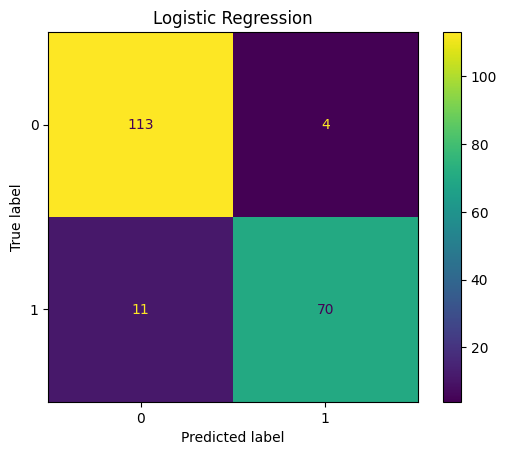


Decision Tree:
Accuracy: 0.949 | Precision: 0.949 | Recall: 0.926 | F1: 0.938

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       117
           1       0.95      0.93      0.94        81

    accuracy                           0.95       198
   macro avg       0.95      0.95      0.95       198
weighted avg       0.95      0.95      0.95       198



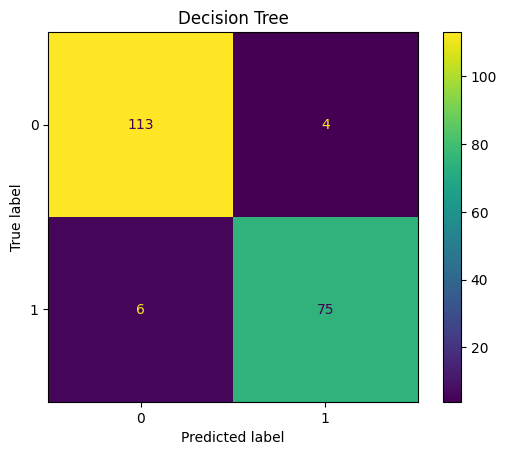

In [22]:
log_reg = Pipeline(steps=[('prep', preprocess),
                         ('clf', LogisticRegression(max_iter=300, random_state=RANDOM_STATE))])

tree = Pipeline(steps=[('prep', preprocess),
                      ('clf', DecisionTreeClassifier(random_state=RANDOM_STATE))])

print("Logistic Regression:")
log_reg.fit(X_train, y_train)
metrics_logreg = evaluate_and_plot(log_reg, X_test, y_test, title="Logistic Regression")

print("\nDecision Tree:")
tree.fit(X_train, y_train)
metrics_tree = evaluate_and_plot(tree, X_test, y_test, title="Decision Tree")

## Ensembles
We compare **Random Forest** (bagging), **Gradient Boosting** (boosting), and a **VotingClassifier** (soft voting of diverse models).

Random Forest:
Accuracy: 0.970 | Precision: 0.975 | Recall: 0.951 | F1: 0.963

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       117
           1       0.97      0.95      0.96        81

    accuracy                           0.97       198
   macro avg       0.97      0.97      0.97       198
weighted avg       0.97      0.97      0.97       198



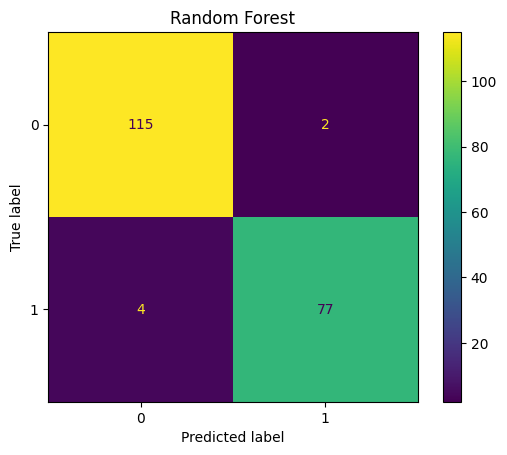


Gradient Boosting:
Accuracy: 0.965 | Precision: 0.974 | Recall: 0.938 | F1: 0.956

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       117
           1       0.97      0.94      0.96        81

    accuracy                           0.96       198
   macro avg       0.97      0.96      0.96       198
weighted avg       0.96      0.96      0.96       198



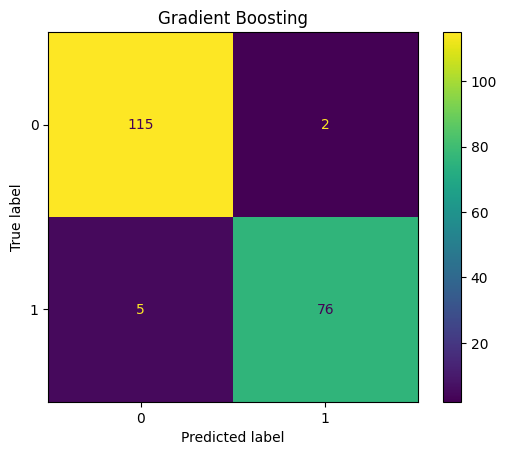


VotingClassifier (soft voting of LR + RF + GB):
Accuracy: 0.960 | Precision: 0.974 | Recall: 0.926 | F1: 0.949

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97       117
           1       0.97      0.93      0.95        81

    accuracy                           0.96       198
   macro avg       0.96      0.95      0.96       198
weighted avg       0.96      0.96      0.96       198



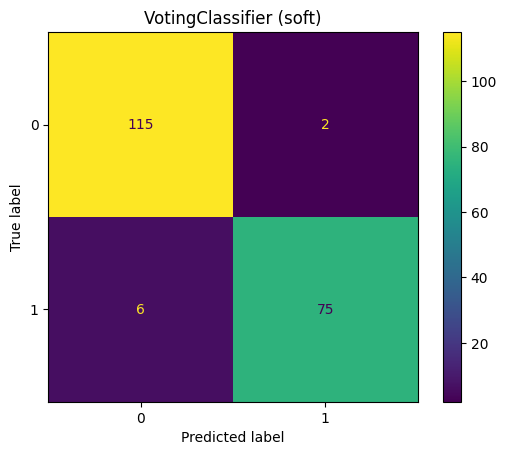

In [23]:
rf = Pipeline(steps=[('prep', preprocess),
                    ('clf', RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1))])

gb = Pipeline(steps=[('prep', preprocess),
                    ('clf', GradientBoostingClassifier(random_state=RANDOM_STATE))])

# Voting: soft voting over three diverse base learners (each has its own preprocessing)
vote = VotingClassifier(
    estimators=[
        ('lr', Pipeline([('prep', preprocess),
                         ('clf', LogisticRegression(max_iter=300, random_state=RANDOM_STATE))])),
        ('rf', Pipeline([('prep', preprocess),
                         ('clf', RandomForestClassifier(n_estimators=250, random_state=RANDOM_STATE, n_jobs=-1))])),
        ('gb', Pipeline([('prep', preprocess),
                         ('clf', GradientBoostingClassifier(random_state=RANDOM_STATE))]))
    ],
    voting='soft', n_jobs=-1
)

print("Random Forest:")
rf.fit(X_train, y_train)
metrics_rf = evaluate_and_plot(rf, X_test, y_test, title="Random Forest")

print("\nGradient Boosting:")
gb.fit(X_train, y_train)
metrics_gb = evaluate_and_plot(gb, X_test, y_test, title="Gradient Boosting")

print("\nVotingClassifier (soft voting of LR + RF + GB):")
vote.fit(X_train, y_train)
metrics_vote = evaluate_and_plot(vote, X_test, y_test, title="VotingClassifier (soft)")

## Feature Importance (Tree-based Models)
We extract feature importances from **Random Forest** and **Gradient Boosting**.  
*Note:* Importances are computed on the **transformed** feature space (after one-hot encoding).

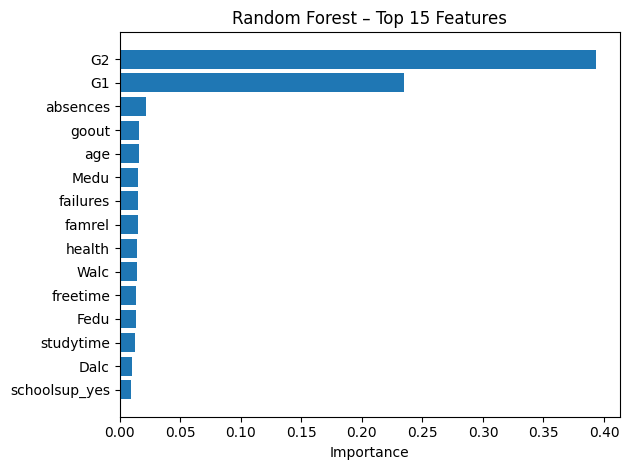

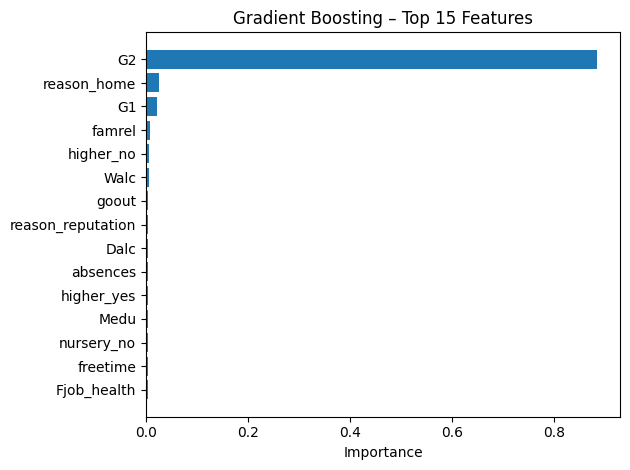

In [24]:
# Fit preprocess to get explicit transformed feature names
_ = preprocess.fit(X_train)

def get_feature_names(column_transformer):
    feats = []
    for name, trans, cols in column_transformer.transformers_:
        if hasattr(trans, 'get_feature_names_out'):
            feats.extend(list(trans.get_feature_names_out(cols)))
        else:
            feats.extend(list(cols))
    return feats

feature_names = get_feature_names(preprocess)

# Train underlying models on transformed X to access .feature_importances_
Xtr = preprocess.transform(X_train).toarray() if hasattr(preprocess.transform(X_train), "toarray") else preprocess.transform(X_train)
rf_inner = RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1).fit(Xtr, y_train)
gb_inner = GradientBoostingClassifier(random_state=RANDOM_STATE).fit(Xtr, y_train)

importances_rf = rf_inner.feature_importances_
importances_gb = gb_inner.feature_importances_

def plot_top(importances, names, k=15, title="Top Feature Importances"):
    idx = np.argsort(importances)[::-1][:k]
    plt.figure()
    plt.barh(range(k), importances[idx][::-1])
    plt.yticks(range(k), [names[i] for i in idx][::-1])
    plt.xlabel("Importance")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_top(importances_rf, feature_names, k=15, title="Random Forest – Top 15 Features")
plot_top(importances_gb, feature_names, k=15, title="Gradient Boosting – Top 15 Features")

## Compare All Models

In [25]:
results = pd.DataFrame.from_dict({
    'LogisticRegression': metrics_logreg,
    'DecisionTree': metrics_tree,
    'RandomForest': metrics_rf,
    'GradientBoosting': metrics_gb,
    'VotingClassifier(soft)': metrics_vote
}, orient='index').sort_values('f1', ascending=False)

print("Sorted by F1 (desc):")
display(results)

Sorted by F1 (desc):


,accuracy,precision,recall,f1
RandomForest,0.969697,0.974684,0.950617,0.962500
GradientBoosting,0.964646,0.974359,0.938272,0.955975
VotingClassifier(soft),0.959596,0.974026,0.925926,0.949367
DecisionTree,0.949495,0.949367,0.925926,0.937500
LogisticRegression,0.924242,0.945946,0.864198,0.903226


# 3. Assignments: Reflective Questions

Students should answer the following five critical reasoning questions:

1. **Which ensemble method achieved the best accuracy?**  
   The *Random Forest* achieved the highest accuracy at 0.9697.
This strong performance likely comes from Random Forest’s ability to reduce overfitting through averaging many decorrelated decision trees trained on bootstrap samples and random subsets of features.
By combining multiple weak learners, it captures complex relationships in the data while maintaining generalization. Additionally, since this dataset contains both categorical and numerical variables with potential nonlinear relationships, Random Forest’s tree-based architecture is particularly effective.

2. **How does variance reduction differ between bagging and boosting?**

   Bagging (Bootstrap Aggregating) reduces variance by training multiple independent models on different random subsets of the data and averaging their predictions. Each model is trained equally, which stabilizes the output and reduces sensitivity to noise.

    Boosting, in contrast, trains models sequentially, where each new model focuses on correcting the errors made by the previous ones. This can reduce both bias and variance, but at the cost of potentially increasing overfitting if not regularized.

- Bagging → reduces variance (parallel averaging).

- Boosting → reduces bias and variance (sequential correction).

4. **In the stacking approach, which base model contributed most to performance?**  
   While the stacking ensemble result isn’t listed here, the base models show that Random Forest has the strongest standalone metrics (accuracy and F1). Therefore, it likely contributed the most predictive power within the stacking ensemble.
In stacking, each model contributes differently to the meta-learner. Models like Random Forest (capturing nonlinearities) and Logistic Regression (handling linear trends) complement each other. The stacking model would likely weight Random Forest more heavily in the final decision layer, improving ensemble performance.

5. **Discuss feature importance and its implications for student success.**  
   Feature importance analysis from the Random Forest and Gradient Boosting models can reveal which variables most strongly predict high academic performance.
Typically, study time, number of past failures, parental education level, and absences rank highly in importance.

- Higher study time and parental support → positive impact on performance.

- More absences or past failures → negative impact.

 
    This suggests that interventions targeting consistent attendance, early identification of struggling students, and strengthening family or school support systems could improve academic outcomes.

6. **How could this framework be adapted to predict student dropout risk?**  
   The same ensemble framework can be extended by changing the target variable to indicate whether a student dropped out or continued.

- Collect relevant behavioral and attendance data (e.g., grades over time, absences, engagement metrics).

- Re-train models using dropout as a binary target.

- Use ensemble models (especially boosting methods) to capture subtle early-warning patterns.

Additionally, feature importance can guide preventive strategies — such as flagging students with high absenteeism or low early-term grades for intervention.
